# Toxic Comment Classification

This notebook builds and compares multiple models for toxic comment classification with merged labels.

**Models**: TF-IDF + LR · Word2Vec + LSTM · BERT + LSTM · BERT + BERT (Fine-tuned)

Sections: 📥 Import Libraries · 📊 Load & Preprocess Data · 🧠 TF-IDF Model · 🔤 Word2Vec + LSTM · 🤗 BERT + LSTM · 🚀 BERT + BERT · 📈 Evaluate Models · 🧩 Sample Predictions

### Requirements
Key dependencies used in this notebook:
- pandas, numpy, scikit-learn
- matplotlib, seaborn
- torch, transformers
- sentence-transformers (Sentence-BERT)
- gensim (Word2Vec)

## 📥 Import Libraries

In [3]:
%pip install gensim

In [4]:
# Imports and global settings
import os, re, warnings, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModel,
    DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
)

# Optional libs (used later)
try:
    from sentence_transformers import SentenceTransformer
except Exception as e:
    SentenceTransformer = None
try:
    from gensim.models import Word2Vec
except Exception as e:
    Word2Vec = None

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Device & logging
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['WANDB_DISABLED'] = 'true'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
from transformers.utils.logging import set_verbosity_error
set_verbosity_error()
print(f'Using device: {DEVICE}')

Using device: cuda


## 📊 Load & Preprocess Data

In [5]:
# Configuration - use all data for best performance
sample_size = None  # set to None to use full dataset (~160k samples)
data_path = '/content/train.csv'  # adjust if needed

# Load data
df = pd.read_csv(data_path)
orig_labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df = df[['comment_text'] + orig_labels].dropna(subset=['comment_text']).reset_index(drop=True)

# Merge labels into 3 categories
df['toxic']     = ((df['toxic'] == 1) | (df['severe_toxic'] == 1)).astype(int)
df['offensive'] = ((df['obscene'] == 1) | (df['threat'] == 1)).astype(int)
df['abusive']   = ((df['insult'] == 1) | (df['identity_hate'] == 1)).astype(int)
new_labels = ['toxic','offensive','abusive']

# Simple text cleaning
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text_clean'] = df['comment_text'].apply(clean_text)

# Reduce to sample_size for fast demos
if sample_size is not None and len(df) > sample_size:
    df = df.iloc[:sample_size].copy()

# Train/test split (multi-label; simple split for demo)
X_text = df['text_clean']
X_raw  = df['comment_text']
y      = df[new_labels]
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=SEED)
# Keep original (non-clean) for BERT/SBERT
X_train_raw = df.loc[X_train.index, 'comment_text']
X_test_raw  = df.loc[X_test.index,  'comment_text']

print(f'Data loaded: {len(df)} total samples')
print(f'Train: {len(X_train)}, Test: {len(X_test)}')
print('Label counts (merged):')
print(y.sum().to_dict())

Data loaded: 159571 total samples
Train: 127656, Test: 31915
Label counts (merged):
{'toxic': 15294, 'offensive': 8626, 'abusive': 8122}


## Utilities

In [9]:
# Evaluation utilities (unified across models)
def evaluate_and_report(y_true, y_pred, class_names, title=None):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    f1w = f1_score(y_true, y_pred, average='weighted')
    if title: print(f'\n=== {title} ===')
    print(f'Accuracy: {acc:.4f} | F1-macro: {f1m:.4f} | F1-weighted: {f1w:.4f}')
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    return {'model': title or 'model', 'accuracy': acc, 'f1_macro': f1m, 'f1_weighted': f1w}

def plot_confusions(y_true, y_pred, class_names):
    n = len(class_names)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
    if n == 1: axes = [axes]
    for i, name in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'{name}'); axes[i].set_xlabel('Pred'); axes[i].set_ylabel('True')
    plt.tight_layout(); plt.show()

def to_numpy_labels(df_labels):
    return df_labels.values.astype(int)

Y_train_np = to_numpy_labels(y_train)
Y_test_np  = to_numpy_labels(y_test)

## 🧠 TF-IDF Model


=== TF-IDF + Logistic Regression ===
Accuracy: 0.8825 | F1-macro: 0.6762 | F1-weighted: 0.6785
              precision    recall  f1-score   support

       toxic       0.57      0.85      0.69      3056
   offensive       0.60      0.88      0.72      1743
     abusive       0.49      0.87      0.63      1681

   micro avg       0.56      0.86      0.68      6480
   macro avg       0.56      0.87      0.68      6480
weighted avg       0.56      0.86      0.68      6480
 samples avg       0.07      0.08      0.07      6480



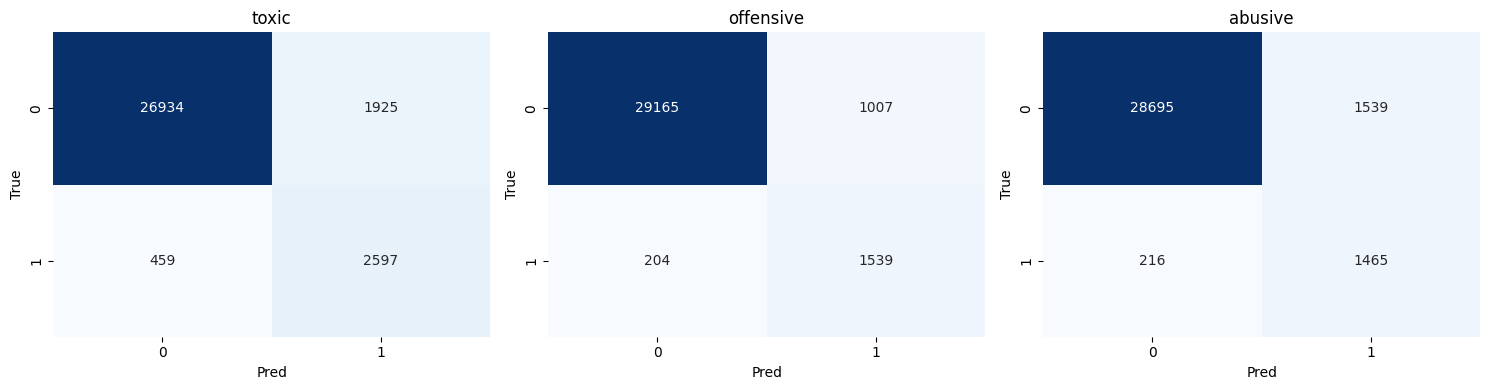

In [10]:
# Train TF-IDF + Logistic Regression baseline with class balancing
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
Xtr_tfidf = vectorizer.fit_transform(X_train)
Xte_tfidf = vectorizer.transform(X_test)

clf_tfidf = OneVsRestClassifier(LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=-1, random_state=SEED))
clf_tfidf.fit(Xtr_tfidf, y_train)
y_pred_tfidf = clf_tfidf.predict(Xte_tfidf)

metrics_tfidf = evaluate_and_report(Y_test_np, y_pred_tfidf, new_labels, title='TF-IDF + Logistic Regression')
plot_confusions(Y_test_np, y_pred_tfidf, new_labels)

## 🔤 Word2Vec + LSTM

Epoch 1: train 0.8753 | val 0.8118
Epoch 2: train 0.5797 | val 0.4485
Epoch 3: train 0.4384 | val 0.4163
Epoch 4: train 0.3694 | val 0.4097
Epoch 5: train 0.3379 | val 0.3956

=== Word2Vec + LSTM ===
Accuracy: 0.8777 | F1-macro: 0.6419 | F1-weighted: 0.6523
              precision    recall  f1-score   support

       toxic       0.56      0.90      0.69      3056
   offensive       0.48      0.94      0.64      1743
     abusive       0.44      0.92      0.60      1681

   micro avg       0.50      0.92      0.65      6480
   macro avg       0.49      0.92      0.64      6480
weighted avg       0.51      0.92      0.65      6480
 samples avg       0.07      0.09      0.07      6480



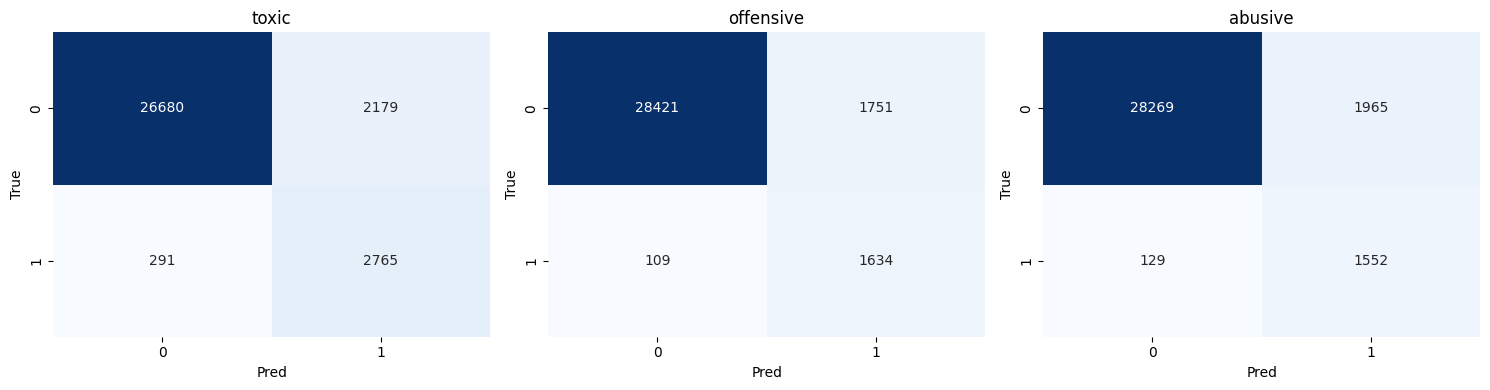

In [11]:
# Train Word2Vec embeddings (optimized for full dataset)
def simple_tokenize(s):
    return [w for w in clean_text(s).split() if w]

sentences_train = [simple_tokenize(t) for t in X_train_raw]
sentences_test  = [simple_tokenize(t) for t in X_test_raw]

if Word2Vec is None:
    raise ImportError('gensim not available; please install gensim to run Word2Vec section')
w2v_dim = 100
# Use min_count=5 with full dataset to filter rare words and speed up training
w2v = Word2Vec(sentences=sentences_train, vector_size=w2v_dim, window=5, min_count=5, workers=4, epochs=5, seed=SEED)

# Build vocab index
word_index = {w: i+1 for i, w in enumerate(w2v.wv.index_to_key)}
vocab_size = len(word_index) + 1

def to_indices(tokens, max_len=100):
    ids = [word_index.get(w, 0) for w in tokens][:max_len]
    if len(ids) < max_len: ids += [0]*(max_len-len(ids))
    return ids

Xtr_idx = np.array([to_indices(t) for t in sentences_train], dtype=np.int64)
Xte_idx = np.array([to_indices(t) for t in sentences_test],  dtype=np.int64)

# Embedding matrix
emb_matrix = np.zeros((vocab_size, w2v_dim), dtype=np.float32)
for w, i in word_index.items():
    if w in w2v.wv: emb_matrix[i] = w2v.wv[w]

class LSTMDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

class LSTMNet(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden=128, num_labels=3, emb_weights=None):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        if emb_weights is not None:
            self.emb.weight.data.copy_(torch.tensor(emb_weights))
            self.emb.weight.requires_grad = False  # freeze embeddings for speed
        self.lstm = nn.LSTM(emb_dim, hidden, batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden*2, num_labels)
    def forward(self, x):
        x = self.emb(x)
        out, _ = self.lstm(x)
        out = self.drop(out[:, -1, :])
        return self.fc(out)

# Train/val split for early stopping
Xtr_idx_tr, Xtr_idx_val, Y_tr, Y_val = train_test_split(Xtr_idx, Y_train_np, test_size=0.2, random_state=SEED)

train_ds = LSTMDataset(Xtr_idx_tr, Y_tr); val_ds = LSTMDataset(Xtr_idx_val, Y_val); test_ds = LSTMDataset(Xte_idx, Y_test_np)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

lstm_model = LSTMNet(vocab_size, w2v_dim, hidden=96, num_labels=3, emb_weights=emb_matrix).to(DEVICE)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, lstm_model.parameters()), lr=1e-3)

# Add class weights for imbalanced labels
pos_counts = Y_train_np.sum(axis=0)
neg_counts = len(Y_train_np) - pos_counts
pos_weight = torch.tensor(neg_counts / (pos_counts + 1e-5), dtype=torch.float32).to(DEVICE)
crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

best_val = float('inf'); patience=2; bad=0
for epoch in range(5):  # increase epochs for full dataset
    lstm_model.train(); tr_loss=0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(); logits = lstm_model(xb); loss = crit(logits, yb); loss.backward(); opt.step(); tr_loss += loss.item()
    lstm_model.eval(); val_loss=0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = lstm_model(xb); val_loss += crit(logits, yb).item()
    print(f'Epoch {epoch+1}: train {tr_loss/len(train_loader):.4f} | val {val_loss/len(val_loader):.4f}')
    if val_loss < best_val: best_val = val_loss; bad=0
    else:
        bad += 1
        if bad > patience: print('Early stopping.'); break

# Predict on test
lstm_model.eval(); preds=[]
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(DEVICE)
        prob = torch.sigmoid(lstm_model(xb)).cpu().numpy()
        preds.append((prob>0.5).astype(int))
y_pred_lstm = np.vstack(preds)

metrics_lstm = evaluate_and_report(Y_test_np, y_pred_lstm, new_labels, title='Word2Vec + LSTM')
plot_confusions(Y_test_np, y_pred_lstm, new_labels)

## 🤗 BERT Embeddings + LSTM

Generating BERT embeddings (frozen encoder)...
BERT embeddings shape: (127656, 768)

Training BERT+LSTM model...
Epoch 1: train 0.4732 | val 0.4648
Epoch 2: train 0.4295 | val 0.4349
Epoch 3: train 0.4101 | val 0.4476
Epoch 4: train 0.4013 | val 0.4282
Epoch 5: train 0.3914 | val 0.4296
Epoch 6: train 0.3818 | val 0.4290
Epoch 7: train 0.3759 | val 0.4143
Epoch 8: train 0.3665 | val 0.4196

=== BERT + LSTM ===
Accuracy: 0.8603 | F1-macro: 0.6019 | F1-weighted: 0.6128
              precision    recall  f1-score   support

       toxic       0.51      0.90      0.65      3056
   offensive       0.49      0.87      0.63      1743
     abusive       0.37      0.92      0.53      1681

   micro avg       0.46      0.90      0.61      6480
   macro avg       0.46      0.90      0.60      6480
weighted avg       0.47      0.90      0.61      6480
 samples avg       0.07      0.09      0.07      6480



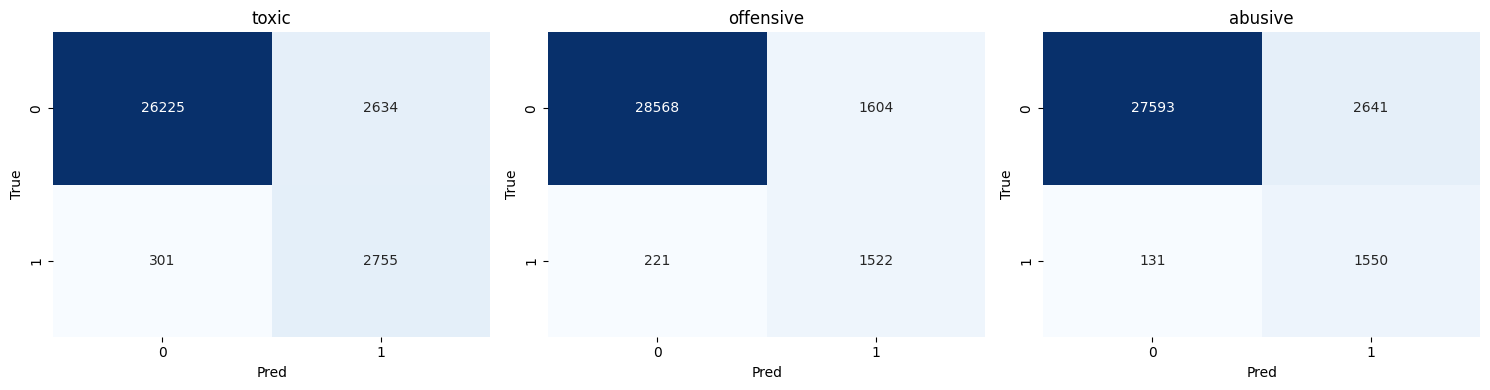

In [12]:
# Use BERT embeddings (frozen) + LSTM classifier
from transformers import DistilBertTokenizerFast, DistilBertModel

print('Generating BERT embeddings (frozen encoder)...')
bert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
bert_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased').to(DEVICE)
bert_encoder.eval()  # freeze BERT encoder

# Generate embeddings for train and test
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoded = bert_tokenizer(batch, truncation=True, padding=True, max_length=128, return_tensors='pt')
        encoded = {k: v.to(DEVICE) for k, v in encoded.items()}
        with torch.no_grad():
            outputs = bert_encoder(**encoded)
            # Use [CLS] token embedding (first token)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

X_train_bert = get_bert_embeddings(X_train_raw.tolist())
X_test_bert = get_bert_embeddings(X_test_raw.tolist())

print(f'BERT embeddings shape: {X_train_bert.shape}')

# LSTM classifier on top of BERT embeddings (improved architecture)
class BERTLSTMNet(nn.Module):
    def __init__(self, bert_dim=768, hidden=256, num_labels=3):  # increased hidden size
        super().__init__()
        self.lstm = nn.LSTM(bert_dim, hidden, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)  # 2 layers
        self.drop = nn.Dropout(0.4)  # increased dropout
        self.fc = nn.Linear(hidden*2, num_labels)
    def forward(self, x):
        # x shape: (batch, bert_dim) -> need (batch, seq=1, bert_dim)
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = self.drop(out[:, -1, :])
        return self.fc(out)

# Create datasets
class BERTLSTMDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

# Train/val split
Xtr_bert_tr, Xtr_bert_val, Y_bert_tr, Y_bert_val = train_test_split(X_train_bert, Y_train_np, test_size=0.2, random_state=SEED)

train_ds_bert = BERTLSTMDataset(Xtr_bert_tr, Y_bert_tr)
val_ds_bert = BERTLSTMDataset(Xtr_bert_val, Y_bert_val)
test_ds_bert = BERTLSTMDataset(X_test_bert, Y_test_np)

train_loader_bert_lstm = DataLoader(train_ds_bert, batch_size=32, shuffle=True)
val_loader_bert_lstm = DataLoader(val_ds_bert, batch_size=64, shuffle=False)
test_loader_bert_lstm = DataLoader(test_ds_bert, batch_size=64, shuffle=False)

bert_lstm_model = BERTLSTMNet(bert_dim=768, hidden=256, num_labels=3).to(DEVICE)
opt_bert_lstm = torch.optim.Adam(bert_lstm_model.parameters(), lr=5e-4, weight_decay=1e-5)  # lower lr, add weight decay

# Add class weights for imbalanced labels
pos_counts = Y_train_np.sum(axis=0)
neg_counts = len(Y_train_np) - pos_counts
pos_weight = torch.tensor(neg_counts / (pos_counts + 1e-5), dtype=torch.float32).to(DEVICE)
crit_bert_lstm = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print('\nTraining BERT+LSTM model...')
best_val_bert = float('inf'); patience=3; bad=0  # increased patience
for epoch in range(8):  # more epochs
    bert_lstm_model.train(); tr_loss=0
    for xb, yb in train_loader_bert_lstm:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt_bert_lstm.zero_grad()
        logits = bert_lstm_model(xb)
        loss = crit_bert_lstm(logits, yb)
        loss.backward()
        opt_bert_lstm.step()
        tr_loss += loss.item()

    bert_lstm_model.eval(); val_loss=0
    with torch.no_grad():
        for xb, yb in val_loader_bert_lstm:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = bert_lstm_model(xb)
            val_loss += crit_bert_lstm(logits, yb).item()

    print(f'Epoch {epoch+1}: train {tr_loss/len(train_loader_bert_lstm):.4f} | val {val_loss/len(val_loader_bert_lstm):.4f}')
    if val_loss < best_val_bert: best_val_bert = val_loss; bad=0
    else:
        bad += 1
        if bad > patience: print('Early stopping.'); break

# Predict on test with optimized threshold
bert_lstm_model.eval(); preds_bert_lstm=[]; probs_bert_lstm=[]
with torch.no_grad():
    for xb, _ in test_loader_bert_lstm:
        xb = xb.to(DEVICE)
        prob = torch.sigmoid(bert_lstm_model(xb)).cpu().numpy()
        probs_bert_lstm.append(prob)
probs_bert_lstm = np.vstack(probs_bert_lstm)

# Use higher threshold to improve precision
threshold = 0.6  # increased from 0.5
y_pred_bert_lstm = (probs_bert_lstm > threshold).astype(int)

metrics_bert_lstm = evaluate_and_report(Y_test_np, y_pred_bert_lstm, new_labels, title='BERT + LSTM')
plot_confusions(Y_test_np, y_pred_bert_lstm, new_labels)

## 🚀 Fine-Tune BERT (BERT + BERT)

Using device: cuda

🚀 Fine-tuning DistilBERT on cuda (Memory Optimized)...
{'loss': 0.4744, 'grad_norm': 0.46765974164009094, 'learning_rate': 4.9923110720562394e-05, 'epoch': 0.006266842138246537}
{'loss': 0.2705, 'grad_norm': 0.517044186592102, 'learning_rate': 4.9766193823750944e-05, 'epoch': 0.012533684276493075}
{'eval_loss': 0.22709053754806519, 'eval_accuracy': 0.898355005483315, 'eval_f1_macro': 0.0, 'eval_runtime': 18.4511, 'eval_samples_per_second': 1729.705, 'eval_steps_per_second': 108.124, 'epoch': 0.012533684276493075}
{'loss': 0.2236, 'grad_norm': 0.7410346269607544, 'learning_rate': 4.9609276926939495e-05, 'epoch': 0.018800526414739612}
{'loss': 0.2165, 'grad_norm': 0.9078258872032166, 'learning_rate': 4.9452360030128045e-05, 'epoch': 0.02506736855298615}
{'eval_loss': 0.19794882833957672, 'eval_accuracy': 0.898355005483315, 'eval_f1_macro': 0.0, 'eval_runtime': 17.9639, 'eval_samples_per_second': 1776.618, 'eval_steps_per_second': 111.056, 'epoch': 0.02506736855298615}

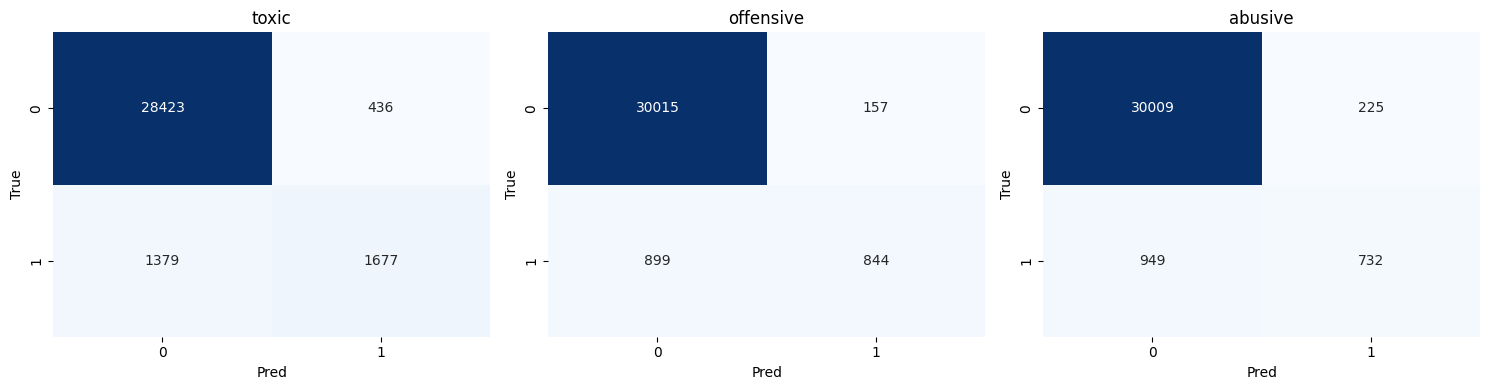

In [22]:
# ==================== Fine-tune DistilBERT (Memory-Optimized) ==================== #
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# Device & logging
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

# ==================== TOKENIZER & MODEL ==================== #
tokenizer_ft = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

bert_model_ft = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,
    problem_type="multi_label_classification"
).to(DEVICE)

# Freeze encoder layers (train only classifier head)
for param in bert_model_ft.distilbert.parameters():
    param.requires_grad = False

# ==================== DATASET CLASS ==================== #
class ToxicDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer_ft(
            texts, truncation=True, padding="max_length", max_length=64  # reduced seq length
        )
        self.labels = labels

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# ==================== DATASETS ==================== #
train_dataset_ft = ToxicDataset(X_train_raw.tolist(), Y_train_np)
test_dataset_ft = ToxicDataset(X_test_raw.tolist(), Y_test_np)

# ==================== TRAINING ARGS (Memory Efficient) ==================== #
training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=2,                     # reduced epochs
    per_device_train_batch_size=8,          # reduced batch size
    per_device_eval_batch_size=16,
    warmup_steps=50,
    logging_steps=100,
    eval_strategy="steps",            # FIX: correct parameter name
    eval_steps=200,
    save_strategy="steps",                  # set to steps
    save_steps=200,                         # save every eval step
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    seed=SEED,
    report_to="none",
    fp16=torch.cuda.is_available(),         # use mixed precision if possible
)

# ==================== METRICS ==================== #
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "f1_macro": f1m}

# ==================== TRAINER ==================== #
trainer = Trainer(
    model=bert_model_ft,
    args=training_args,
    train_dataset=train_dataset_ft,
    eval_dataset=test_dataset_ft,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

# ==================== TRAINING ==================== #
print(f"\n🚀 Fine-tuning DistilBERT on {DEVICE} (Memory Optimized)...")
trainer.train()

# ==================== EVALUATION ==================== #
bert_model_ft.eval()
y_pred_bert_ft = []
batch_size = 16

with torch.no_grad():
    for i in range(0, len(test_dataset_ft), batch_size):
        batch_data = [test_dataset_ft[j] for j in range(i, min(i + batch_size, len(test_dataset_ft)))]
        batch = {k: torch.stack([b[k] for b in batch_data]).to(DEVICE) for k in batch_data[0] if k != "labels"}
        logits = bert_model_ft(**batch).logits
        preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
        y_pred_bert_ft.extend(preds)

y_pred_bert_ft = np.array(y_pred_bert_ft)

metrics_bert_ft = evaluate_and_report(Y_test_np, y_pred_bert_ft, new_labels, title="Fine-tuned DistilBERT (Optimized)")
plot_confusions(Y_test_np, y_pred_bert_ft, new_labels)

## 📈 Evaluate Models

In [28]:
# Compare metrics across models
results = [metrics_tfidf, metrics_lstm, metrics_bert_lstm, metrics_bert_ft]
cmp = pd.DataFrame(results)
print('=== MODEL COMPARISON ===')
print(cmp.to_string(index=False))

=== MODEL COMPARISON ===
                            model  accuracy  f1_macro  f1_weighted
     TF-IDF + Logistic Regression  0.882532  0.676152     0.678512
                  Word2Vec + LSTM  0.877675  0.641896     0.652324
                      BERT + LSTM  0.860316  0.601855     0.612816
Fine-tuned DistilBERT (Optimized)  0.915244  0.606331     0.615442


## 🧩 Sample Predictions

In [36]:
# Sample predictions on test examples
test_samples = [
    "You are such an idiot and a loser!",
    "That's an interesting perspective, thanks for sharing.",
    "F*** you and your stupid opinions!"
]

def predict_labels(text, model_name):
    if model_name == 'tfidf':
        vec = vectorizer.transform([clean_text(text)])
        # Use predict for multi-label classification
        pred = clf_tfidf.predict(vec).flatten()
        # For probabilities, use decision_function and sigmoid
        decision = clf_tfidf.decision_function(vec)
        probs = 1 / (1 + np.exp(-decision))  # sigmoid
        if probs.ndim > 1:
            probs = probs.flatten()
    elif model_name == 'w2v_lstm':
        tokens = simple_tokenize(text)
        ids = to_indices(tokens)
        x = torch.tensor([ids], dtype=torch.long).to(DEVICE)
        lstm_model.eval()
        with torch.no_grad():
            logits = lstm_model(x)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
        pred = (probs > 0.5).astype(int)
    elif model_name == 'bert_lstm':
        # Get BERT embedding for the text
        emb = get_bert_embeddings([text])
        x = torch.tensor(emb, dtype=torch.float32).to(DEVICE)
        bert_lstm_model.eval()
        with torch.no_grad():
            logits = bert_lstm_model(x)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
        pred = (probs > 0.5).astype(int)
    elif model_name == 'bert_ft':
        # Match training max_length for consistency and speed
        enc = tokenizer_ft([text], truncation=True, padding=True, max_length=64, return_tensors='pt')
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        bert_model_ft.eval()
        with torch.no_grad():
            logits = bert_model_ft(**enc).logits
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
        pred = (probs > 0.5).astype(int)
    else:
        return None, None
    return pred, probs

print('\n=== Sample Predictions ===')
for i, txt in enumerate(test_samples):
    print(f'\n[{i+1}] "{txt}"')
    for model_name in ['tfidf', 'w2v_lstm', 'bert_lstm', 'bert_ft']:
        pred, probs = predict_labels(txt, model_name)
        if pred is None:
            continue
        labels_on = [new_labels[j] for j in range(len(pred)) if pred[j]==1]
        labels_str = ', '.join(labels_on) if labels_on else '(none)'
        print(f'  {model_name:10s}: {labels_str:30s} (probs: {probs})')


=== Sample Predictions ===

[1] "You are such an idiot and a loser!"
  tfidf     : toxic, offensive, abusive      (probs: [0.99998988 0.99479576 0.99999267])
  w2v_lstm  : toxic, offensive, abusive      (probs: [0.99276924 0.9855839  0.97889906])
  bert_lstm : toxic, offensive, abusive      (probs: [0.98523074 0.9100451  0.96827626])
  bert_ft   : toxic, offensive, abusive      (probs: [0.86838096 0.55895907 0.5836187 ])

[2] "That's an interesting perspective, thanks for sharing."
  tfidf     : (none)                         (probs: [0.0261586  0.03132436 0.02663152])
  w2v_lstm  : (none)                         (probs: [0.02165006 0.00622612 0.00269944])
  bert_lstm : (none)                         (probs: [0.021526   0.00783839 0.00504838])
  bert_ft   : (none)                         (probs: [0.02620541 0.00978388 0.01102947])

[3] "F*** you and your stupid opinions!"
  tfidf     : toxic, offensive, abusive      (probs: [0.99903076 0.9565173  0.98606799])
  w2v_lstm  : toxic, offe

# Download

In [40]:
# Save the fine-tuned DistilBERT model and tokenizer
bert_model_ft.save_pretrained("./bert_ft_model")
tokenizer_ft.save_pretrained("./bert_ft_model")

print("✅ Fine-tuned BERT model saved to ./bert_ft_model")

✅ Fine-tuned BERT model saved to ./bert_ft_model


In [41]:
!zip -r bert_ft_model.zip bert_ft_model

  adding: bert_ft_model/ (stored 0%)
  adding: bert_ft_model/vocab.txt (deflated 53%)
  adding: bert_ft_model/special_tokens_map.json (deflated 42%)
  adding: bert_ft_model/model.safetensors (deflated 8%)
  adding: bert_ft_model/tokenizer.json (deflated 71%)
  adding: bert_ft_model/tokenizer_config.json (deflated 75%)
  adding: bert_ft_model/config.json (deflated 49%)
